<a href="https://colab.research.google.com/github/BrunoPinos/FormationDataAnalyst/blob/main/p5_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [34]:
# data analysis and wrangling
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

# text
import re
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from IPython.display import display, HTML

# Save objects
import joblib

# Set working directory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/P5')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import

**SQL**  
I get 50,000 posts for every 10,000,000, the posts retrieved have a score> 10 and are questions

for n in range(1, 7):  
SELECT Id, Body, Title, Tags  
FROM Posts  
WHERE (Score >= 10) AND (PostTypeId = 1) AND (Id < n * 10000000) AND (  
  Id >= (n - 1) * 10000000

**Read**

In [4]:
n_files = 6
list_files = [pd.read_csv('./Data/QueryResults (' + str(n+1) + ').csv',
                          index_col='Id') for n in range(n_files)]

df = pd.concat(list_files, axis=0)
df

,Body,Title,Tags
Id,,,
10000005,<blockquote>\n<p><strong>Possible Duplicate:</...,PHP Sort array by field?,<php><arrays><sorting>
10000020,<p>I am attempting to post form data to a goog...,AJAX post to google spreadsheet,<jquery><ajax><google-apps-script><google-sheets>
10000074,<p>I'm just starting to look into the world of...,Which FRP package to choose?,<haskell><frp><reactive-banana>
10000083,<p>I want to make an eventHandler that passes ...,Javascript event handler with parameters,<javascript><events><event-handling><handler>
10000226,<p>A string is called a square string if it ca...,Square Subsequence,<string><algorithm><dynamic-programming>
...,...,...,...
1213074,<p>I'm trying to drag data from the Winforms p...,"WinForms Interop, Drag & Drop from WinForms ->...",<wpf><winforms><interop><drag-and-drop>
1213127,<p>Is there a way for a Java program to detect...,Detect OS Sleep and Wake Up events in Java,<java><mysql><database-connection><sleep>
1213137,<p>I know I can change the UITableView propert...,Is there a way to remove the separator line fr...,<iphone><uitableview>


# Pretreatment

I create text with title + body.  
I follow transformations on 2 question.  

In [5]:
sample = np.random.choice(len(df), 2)

def random_display(docs, sample):
    for s in sample:
        print(docs.iloc[s], '\n'+'-'*20+'\n'*2)

In [6]:
texts = (df.Title + ' ' +df.Body)


random_display(texts, sample)

How to get UIMenuController work for a custom view? <p>I'm trying to get the following code work:</p>

<pre><code>UIMenuController * menu = [UIMenuController sharedMenuController];
[menu setTargetRect: CGRectMake(100, 100, 100, 100) inView: self.view];
[menu setMenuVisible: YES animated: YES];
</code></pre>

<p>The menu instance is ready but it doesn't show - the width is always zero.</p>

<p>Or is there some sample code on this <code>UIPasteboard/UIMenuController</code> topic?</p>
 
--------------------


How to use / refer to the negation of a boolean function in Scala? <p>I'm trying to use the negation of a boolean function in Scala, such as:</p>

<pre><code>def someFunction(x: Set, p: Int =&gt; Boolean): Boolean = 
    someOtherFunction(x, !p)
</code></pre>

<p>But I get the error:</p>

<pre><code> value unary_! is not a member of Int =&gt; Boolean
</code></pre>

<p>How can I refer to the negation of p? </p>
 
--------------------




The first part of our job is to clean up the text

1.   Remove superfluous parts: code parts, HTML tags, punctuation... 
2.   Create tokens: i.e. separate their text for each document into a list of  words
3.   Remove stopwords: words considered too common to be interesting in our analysis
4.   Lemmatize: transform all the words into a basic form whatever the form in which it appears in the document (plural, conjugated verb, feminine form ...)

In [27]:
# Lemmatization function
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(doc, nlp, banned_postags=['PUNCT', 'DET', 'PRON', 'CONJ',
                                            'ADV', 'INTJ']):
    doc = nlp(doc)
    return [token.lemma_ for token in doc if token.pos_ not in banned_postags]
    

# Remove stopwords
stop_words = stopwords.words('english')

# stop_words.extend([])
def remove_stopwords(doc):
    return " ".join([word for word in doc if word not in stop_words]) 

In [28]:
# All processing
texts_cleaned = (texts
                 # delete code parts
                 .apply(lambda x: re.sub('<code>(.|\n)*?</code>', '', x))
                  # remove HTML tags
                 .apply(lambda x: re.sub('<[^<]+?>', '', x))
                 .apply(lambda x: simple_preprocess(x, min_len=3, deacc=False))
                 .apply(remove_stopwords)
                 .apply(lambda x: lemmatization(x, nlp=nlp))
                )

random_display(texts_cleaned, sample)

['get', 'work', 'custom', 'view', 'try', 'get', 'follow', 'code', 'work', 'menu', 'instance', 'ready', 'show', 'width', 'zero', 'sample', 'code', 'topic'] 
--------------------


['use', 'refer', 'negation', 'boolean', 'function', 'scala', 'try', 'use', 'negation', 'boolean', 'function', 'scala', 'get', 'error', 'refer', 'negation'] 
--------------------




In our selected examples, we observe a much smaller number of remaining words, compared to the raw documents.

Now is the time to normalize our text, namely to put it in a format in which our model will be able to understand it. To do this, we will first create a dictionary which will assign a unique identifier to each word present in all the documents. We also display the number of words present in this dictionary

In [29]:
dictionary = Dictionary(texts_cleaned)
print("Taille du dictionnaire: ",len(dictionary))

Taille du dictionnaire:  145399


In order to make sure that these words can help us at least to find interesting patterns in our data at the time of modeling, we remove from the dictionary the words which do not appear in at least 50 different documents.

In [30]:
dictionary.filter_extremes(no_below=50)
print("Taille du dictionnaire: ", len(dictionary))

Taille du dictionnaire:  6499


With this filtering, we have removed more than 80% of the words in the dictionary, which could have been a source of noise once they became descriptors. Also, in order not to have too common words (like stopwords), let's take a look at the most common items

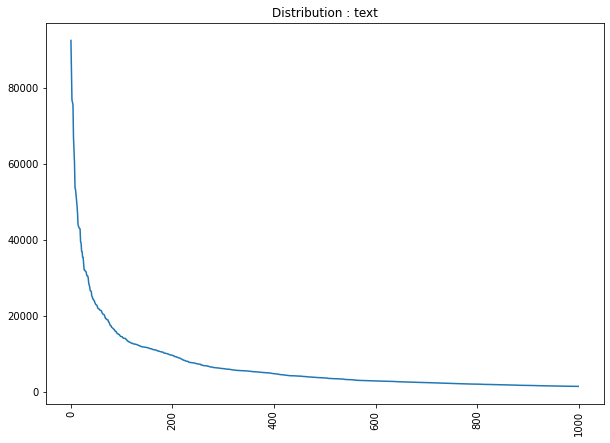

In [35]:
words_sorted = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)
id2token = {value: key for key, value in dictionary.token2id.items()}

list_count = [count for e, (i, count) in enumerate(words_sorted[:1000])]
fig = plt.figure(1, figsize=(10, 7))
sn.lineplot(x = range(0, 1000), y = list_count)
plt.xticks(rotation=90)
plt.title('Distribution : text')
plt.show()

In [37]:
print("Mots les plus fréquents du dictionnaire:")
for e, (i, count) in enumerate(words_sorted[:100]):
    print(f"{e+1:2} {id2token[i]:15} {count:5}")

Mots les plus fréquents du dictionnaire:
 1 get             92579
 2 try             84191
 3 like            76905
 4 work            76314
 5 code            75647
 6 want            67063
 7 way             63534
 8 would           60402
 9 follow          53701
10 find            53344
11 error           51980
12 one             50780
13 file            49105
14 know            47014
15 make            43991
16 run             43631
17 example         43220
18 need            43022
19 create          42933
20 problem         39451
21 see             39242
22 look            37018
23 seem            36943
24 question        35461
25 add             35427
26 set             33683
27 call            32120
28 change          32064
29 time            31854
30 new             31761
31 thank           31535
32 function        30765
33 could           30518
34 method          30516
35 value           30017
36 app             28661
37 help            28054
38 give            27627
39 applic

We decide to delete the 77 most frequent words + 13 others bad words.


In [55]:
to_delete = [id2token[i] for e, (i, count) in enumerate(words_sorted[:77])]

list_append = ['point', 'mean', 'string', 'since', 'base', 'go', 'name', 'may',
               'first', 'can', 'page', 'number', 'answer']

for word in list_append:
  to_delete.append(word) 

bad_ids = [dictionary.token2id[token] for token in to_delete]

dictionary.filter_tokens(bad_ids=bad_ids)

And finally, to conclude our pre-processing part, we create our bag of words. This representation makes it possible to count the number of occurrences of each word in the dictionary for each document. The resulting dataframe will serve as input data to our model

In [56]:
corpus = texts_cleaned.apply(dictionary.doc2bow)
random_display(corpus, sample)

[(100, 1), (104, 1), (267, 1), (299, 1), (370, 1), (398, 1), (492, 1), (787, 1), (1330, 1)] 
--------------------


[(1023, 2), (1381, 2), (2080, 2), (4466, 3)] 
--------------------




I save my objects

In [57]:
joblib.dump(corpus, 'corpus.sav')
joblib.dump(dictionary, 'dictionary.sav')
joblib.dump(df, 'df.sav')
joblib.dump(texts_cleaned, 'texts_cleaned.sav')

['texts_cleaned.sav']